In [1]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from scipy import stats
import networkx as nx
import collections
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.stats as st

# Synthetic Data:

In [2]:
class point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
def flatten(i, j, n):
    return(i * n +j)

def unflatten(k, n):
    j = k % n
    i = int((k-j)/n)
    return(i, j)

def toroidal_distance(p, q, L):
    delta_x = abs(p.x-q.x)
    if(delta_x > 0.5 * L):
        delta_x = L - delta_x
    delta_y = abs(p.y - q.y)
    if(delta_y > 0.5 * L):
        delta_y = L - delta_y
    return(math.sqrt(delta_x**2 + delta_y**2))

In [4]:
n = 10
#  Grid spacing
delta_x = 2.0 * math.pi/n
# Define spatial correlation length as a multiple of Δx
lamda = 3 * delta_x
# Amplitude of variation of the  correlation time 
a = 0.5
# Amplitude of variation of the single-site variance 
b = 0.5
# Define arrays containing all the spatial points in the discretisation
x = np.empty((n,n), dtype=object)
X = np.empty(n*n, dtype=object)
for i in range(n):
    for j in range(n):
        x[i,j] = point(x = i * delta_x, y =  j * delta_x)
        X[flatten(i,j,n)] = x[i,j]

In [5]:
# Define arrays containing the time series parameters and desired spatial correlation structure
N = n*n
phi = np.empty(N, dtype=float)
c = np.empty(N, dtype=float)
sigma = np.empty(N, dtype=float)
alpha = np.empty(N, dtype=float)


for i in range(N):
    xc = X[i].x
    yc = X[i].y
    phi[i] = (0.5 + a * math.sin(xc) * math.sin(yc))
    c[i] = 0.0
    sigma[i] = math.sqrt(1.0 - phi[i]**2)
    alpha[i] = 1.0 + b * math.sin(xc/2.0) * math.sin(yc/2.0)


In [6]:
C = np.empty((N,N), dtype=float)
epsilon = 4.0E-2
for i in range(N):
    for j in range(N):
        d = toroidal_distance(X[i], X[j], 2*math.pi)
        C[i,j] = math.exp(-d/lamda)
        if(i==j):
            C[i,j] = 1 + epsilon
           

#lamda_C <- chol(C)


In [7]:
lamda_C = np.linalg.cholesky(C)

In [8]:
A_diag = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if(i==j):
            p, q =unflatten(i, n)
            A_diag[i,j] = alpha[flatten(p,q,n)]*A_diag[i,j]

In [9]:
lamda_C = np.multiply(lamda_C, A_diag)

In [16]:
M = 2000
A = np.empty((M,N), dtype=float)
data = np.empty((M,N), dtype=float)

random.seed(1234)

A[0,:] = np.random.normal(0, 1, N)
data[0,:] = np.matmul(lamda_C,A[0,:])
for i in range(1,M):
    
    zeta = sigma * np.random.normal(0, 1, N)
    A[i,] = c + (phi * A[i-1,:]) + zeta
    data[i,] = np.matmul(lamda_C,A[i,])


# Network:

In [12]:
def weighted_matrix(data):
    N = data.shape[1]
    pearson_r = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
             pearson_r[i,j] = stats.pearsonr(data[:,i],data[:,j])[0]
    return(pearson_r)
        

## Global Thresholding:

In [13]:
def graph_builder_limit (weighted_matrix,limit):
    #weighted_matrix = np.exp(-np.sqrt(1 - weighted_matrix))
    weighted_matrix = np.absolute(weighted_matrix)
    componenets_number = 0
    adjacency_matrix = np.zeros(weighted_matrix.shape)
    adjacency_matrix[weighted_matrix >= limit] = 1
    G = nx.from_numpy_matrix(adjacency_matrix)
    G = G.to_undirected()
    G.remove_edges_from(G.selfloop_edges())
    #Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    #componenets_number = len(Gcc) 
    componenets_number = nx.number_connected_components(G)
    return(G, componenets_number)

In [14]:
def graph_builder (weighted_matrix):
    weighted_matrix = np.exp(-np.sqrt(1 - weighted_matrix))
    componenets_number = 0
    limit = 1.0
    while componenets_number != 1:
        limit -= 0.01
        adjacency_matrix = np.zeros(weighted_matrix.shape)
        adjacency_matrix[weighted_matrix >= limit] = 1
        G = nx.from_numpy_matrix(adjacency_matrix)
        G = G.to_undirected()
        G.remove_edges_from(G.selfloop_edges())
        #Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        #componenets_number = len(Gcc)
        componenets_number = nx.number_connected_components(G)
    return(G, limit)

In [15]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def momment_of_degree_distribution(G,m):
    k,Pk = degree_distribution(G)
    M = sum((k**m)*Pk)
    return M

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

In [17]:
data.shape

(2000, 100)

In [25]:
r = np.arange(0.1,1.1,0.2)
s = []

In [26]:
for i in range(len(r)):
    m = []
    G = []
    for j in range(0,1600,200):
        m1 = weighted_matrix(data[j:j+200,:])
        G1, c = graph_builder_limit(m1, r[i])
        m2 = weighted_matrix(data[j+200:j+400,:])
        G2, c = graph_builder_limit(m2, r[i])
        G.append(nx.graph_edit_distance(G1, G2))
        m.append(np.linalg.norm(m1-m2))
    s.append(stats.pearsonr(m,G)[0])

KeyboardInterrupt: 

In [11]:
m = weighted_matrix(data)
r = np.arange(0.01,1.01,0.1)

components = []
density = []
S = []

average_degree_pr = []
second_moment_pr = []
variance_pr = []
shannon_entropy_pr = []
transitivity_pr = []
average_cluster_pr = []
average_shortest_path_length_pr = []
diameter_pr = []
global_efficiency_pr = []
local_efficiency_pr = []
average_closeness_pr = []
average_betweennes_pr = []
average_eigenvector_pr = []
average_pagerank_pr = []
assortativity_pr = []


for i in range(len(r)):
    G_pr, c = graph_builder_limit(m, r[i])
    density.append(2 * G_pr.number_of_edges()/(len(G_pr)*(len(G_pr)-1)))
    S.append(len(max(nx.connected_component_subgraphs(G_pr), key=len)))
    components.append(c)
    
    vk_pr = dict(G_pr.degree())
    CLC_pr = nx.closeness_centrality(G_pr)
    KC_pr = dict(nx.core_number(G_pr))
    B_pr = dict(nx.betweenness_centrality(G_pr))
    PR_pr = dict(nx.pagerank(G_pr, alpha=0.85))
    EC_pr = dict(nx.eigenvector_centrality(G_pr, max_iter = 1000))
                  
    
    average_degree_pr.append(momment_of_degree_distribution(G_pr,1))                  #First Moment
    second_moment_pr.append(momment_of_degree_distribution(G_pr,2))                   #Second Moment
    variance_pr.append(momment_of_degree_distribution(G_pr,2) - momment_of_degree_distribution(G_pr,1)**2)     #Variance
    shannon_entropy_pr.append(shannon_entropy(G_pr))                                  #Shanon Entropy
    transitivity_pr.append(nx.transitivity(G_pr))                                     #Transitivity 
    average_cluster_pr.append(nx.average_clustering(G_pr))
    if nx.is_connected(G_pr) == True:
        average_shortest_path_length_pr.append(nx.average_shortest_path_length(G_pr))     #Average Shortest Path
    else:
        average_shortest_path_length_pr.append(0)
    #diameter_pr.append(nx.diameter(G_pr))                                             #Diameter   
    #global_efficiency_pr.append(nx.global_efficiency(G_pr))                           #Efficiency
    #local_efficiency_pr.append(nx.local_efficiency(G_pr))                             #Average Local Efficiency  
    average_closeness_pr.append(np.mean(list(CLC_pr.values())))                       #Average closeness centrality
    average_betweennes_pr.append(np.mean(list(B_pr.values())))                        #Average betweenness centrality
    average_eigenvector_pr.append(np.mean(list(EC_pr.values())))                      #Average eigenvector centrality
    average_pagerank_pr.append(np.mean(list(PR_pr.values())))                         #Average PageRank Centrality
   # assortativity_pr.append(nx.degree_assortativity_coefficient(G_pr))                #Assortativity

In [26]:
G, c = graph_builder_limit(m, 0.01)

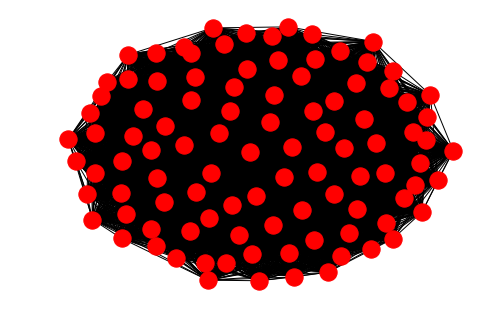

In [27]:
nx.draw(G)

In [28]:
vk = dict(G.degree())
deg = np.empty((10,10), dtype=float)
lat_number = 10
lon_number = 10
for i in range(lat_number):
    for j in range(lon_number):
        index = i*lon_number+j
        if index in vk.keys():
            deg[i,j]=vk[index]
        else:
            deg[i,j]=np.nan

In [32]:
#CLC = nx.closeness_centrality(G_pr)
#KC = dict(nx.core_number(G_pr))
#B = dict(nx.betweenness_centrality(G_pr))
#PR = dict(nx.pagerank(G_pr, alpha=0.85))
#EC = dict(nx.eigenvector_centrality(G_pr, max_iter = 1000))



def degree_builder(dictionary):
    deg = np.empty((10,10), dtype=float)
    lat_number = 10
    lon_number = 10
    for i in range(lat_number):
        for j in range(lon_number):
            index = i*lon_number+j
            if index in dictionary.keys():
                deg[i,j] = dictionary[index]
            else:
                deg[i,j] = np.nan
    return deg

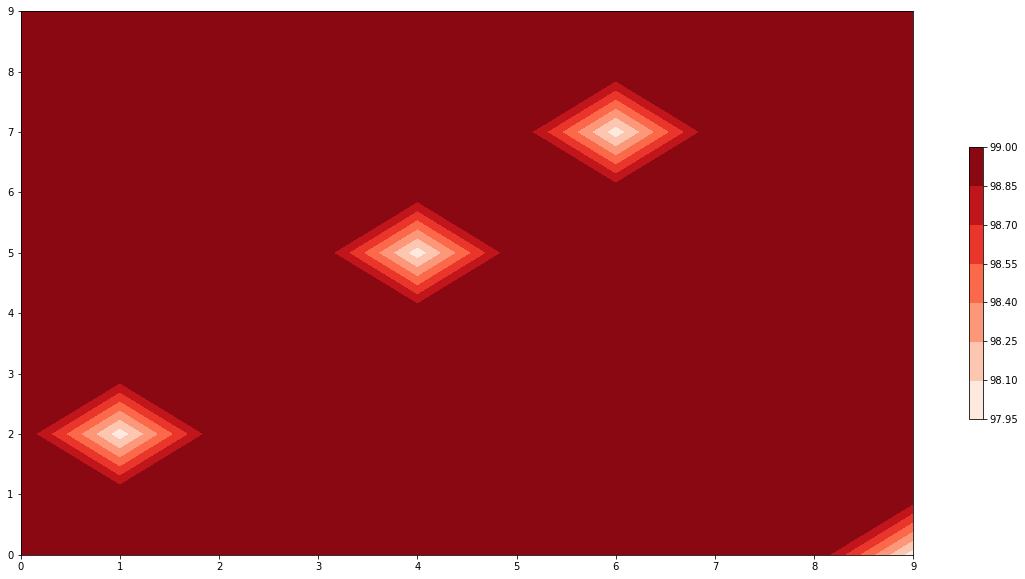

In [29]:
xc = np.linspace(0, 9, num=10)
yc = np.linspace(0, 9, num=10)
xx, yy = np.meshgrid(xc, yc)
fig = plt.figure(figsize=(20,10))

cs = plt.contourf(xx,yy,deg, cmap=plt.cm.Reds)
cbar = plt.colorbar(cs, orientation='vertical', shrink=0.5)

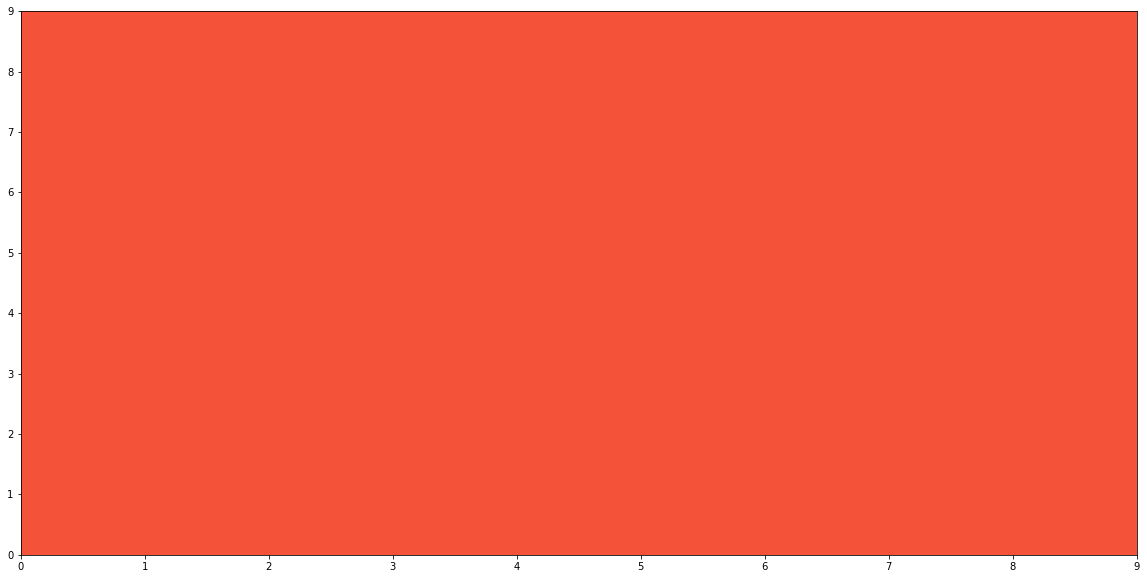

In [44]:
xc = np.linspace(0, 9, num=10)
yc = np.linspace(0, 9, num=10)
xx, yy = np.meshgrid(xc, yc)
fig = plt.figure(figsize=(20,10))


def animate(i): 
    #z = var[i,:,0,:].T
    G, c = graph_builder_limit(m, 0.01*i)
    clustering = nx.clustering(G)
    #vk = dict(G.degree())
    deg = degree_builder(clustering)
    #cont = plt.contourf(x, y, z, 25)
    cs = plt.contourf(xx,yy,deg, cmap=plt.cm.Reds)
    #if (tslice == 0):
    #    plt.title(r't = %1.2e' % t[i] )
    #else:
    #    plt.title(r't = %i' % i)

    return cs 

anim = animation.FuncAnimation(fig, animate,frames=100, interval=200)
anim.save('animation_clustering.mp4')

#cs = plt.contourf(xx,yy,deg, cmap=plt.cm.Reds)
#cbar = plt.colorbar(cs, orientation='vertical', shrink=0.5)

#plt.show()

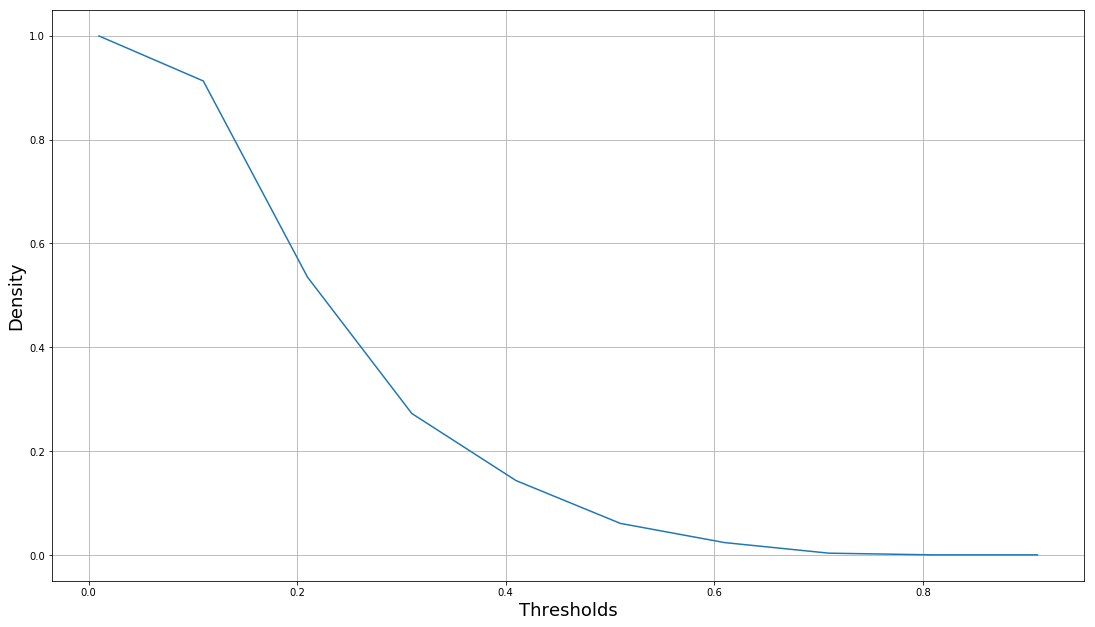

In [35]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
#ax.semilogy(r,density)
ax.plot(r,density)
ax.grid()
ax.set_xlabel("Thresholds",fontsize=18)
ax.set_ylabel("Density",fontsize=18)
plt.show()

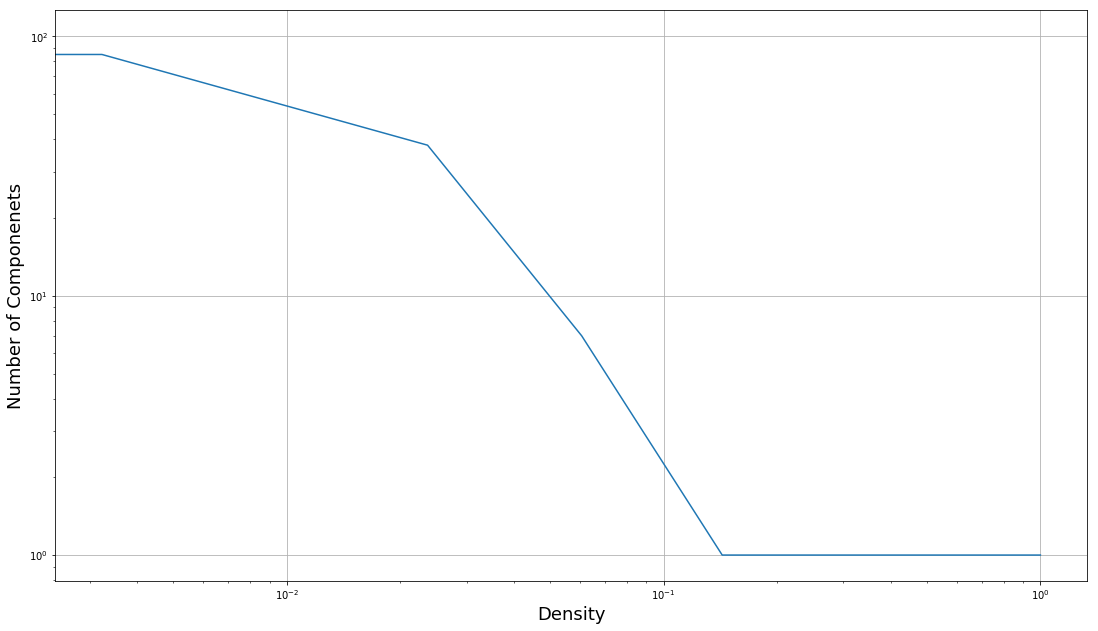

In [20]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.loglog(density,components)
ax.grid()
ax.set_xlabel("Density",fontsize=18)
ax.set_ylabel("Number of Componenets",fontsize=18)

plt.show()

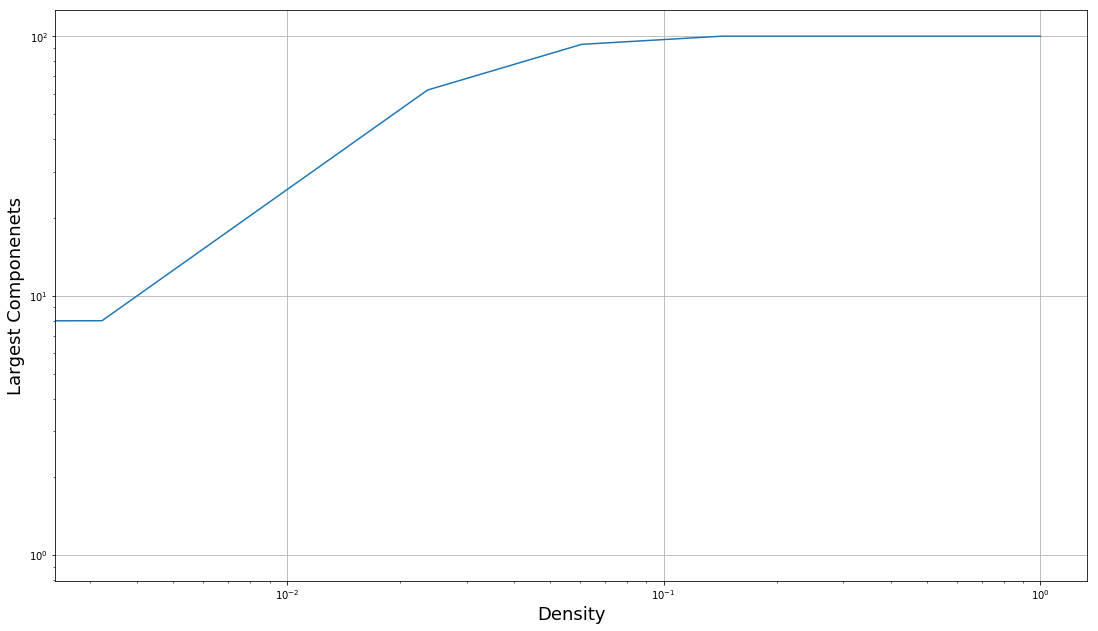

In [21]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.loglog(density,S)
#ax.plot(density,S,'ro-')
ax.grid()
ax.set_xlabel("Density",fontsize=18)
ax.set_ylabel("Largest Componenets",fontsize=18)
plt.show()

In [26]:
average_betweennes_pr

[4.122861265718408e-06,
 0.000888476602762317,
 0.004745413316841887,
 0.00849515563801278,
 0.015116470830756545,
 0.024028035456606877,
 0.013271490414347555,
 0.00014636157493300348,
 0.0,
 0.0]

Text(0.5,0,'Thresholds')

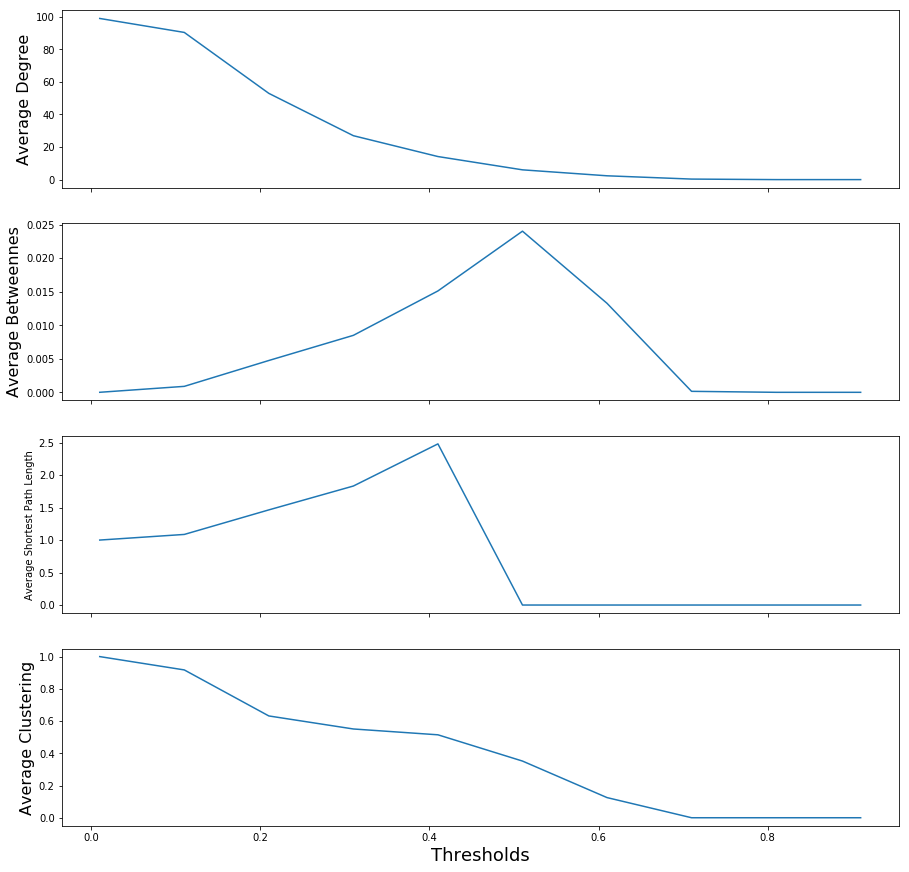

In [25]:
f, axarr = plt.subplots(4, sharex=True)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].plot(r,average_degree_pr)
axarr[0].set_ylabel('Average Degree',fontsize=16)
axarr[1].plot(r,average_betweennes_pr)
axarr[1].set_ylabel('Average Betweennes',fontsize=16)
axarr[2].plot(r,average_shortest_path_length_pr)
axarr[2].set_ylabel('Average Shortest Path Length',fontsize=10)
axarr[3].plot(r,average_cluster_pr)
axarr[3].set_ylabel('Average Clustering',fontsize=16)
axarr[3].set_xlabel('Thresholds',fontsize=18)

# Fisher Transformation Thresholding:

In [45]:
def graph_builder_fisher (weighted_matrix, limit):
    np.fill_diagonal(weighted_matrix, 0)
    Z = abs(np.arctanh(weighted_matrix))
    N = 1000
    SE = 1/math.sqrt(N-3)
    Z = Z/SE
    p = st.norm.cdf(Z)
    
    adjacency_matrix = np.zeros(weighted_matrix.shape)
    adjacency_matrix[p > (1-limit/2)] = 1
    G = nx.from_numpy_matrix(adjacency_matrix)
    G = G.to_undirected()
    G.remove_edges_from(G.selfloop_edges())
    componenets_number = nx.number_connected_components(G)    
    return(G, componenets_number)

In [46]:
m = weighted_matrix(data)
lst = np.arange(0.0,-12.0,-1.0)
r = [10.0 ** num for num in lst]
components = []
density = []
S = []
for i in range(len(r)):
    G, c = graph_builder_fisher(m, r[i])   
    density.append(2 * G.number_of_edges()/(len(G)*(len(G)-1)))
    S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
    components.append(c)

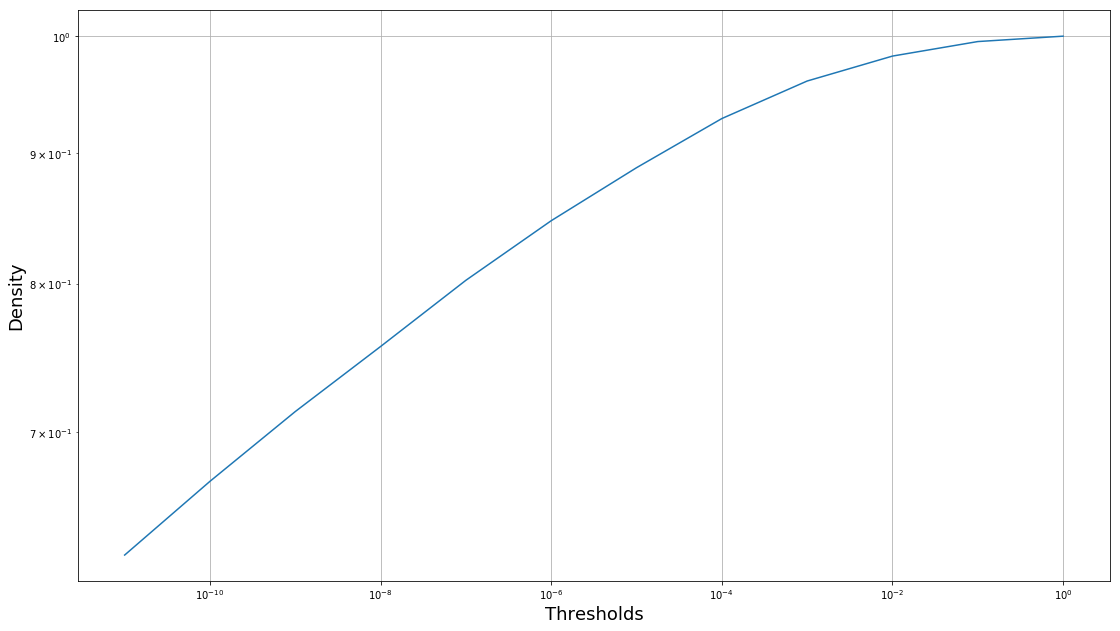

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.loglog(r,density)
ax.grid()
ax.set_xlabel("Thresholds",fontsize=18)
ax.set_ylabel("Density",fontsize=18)
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


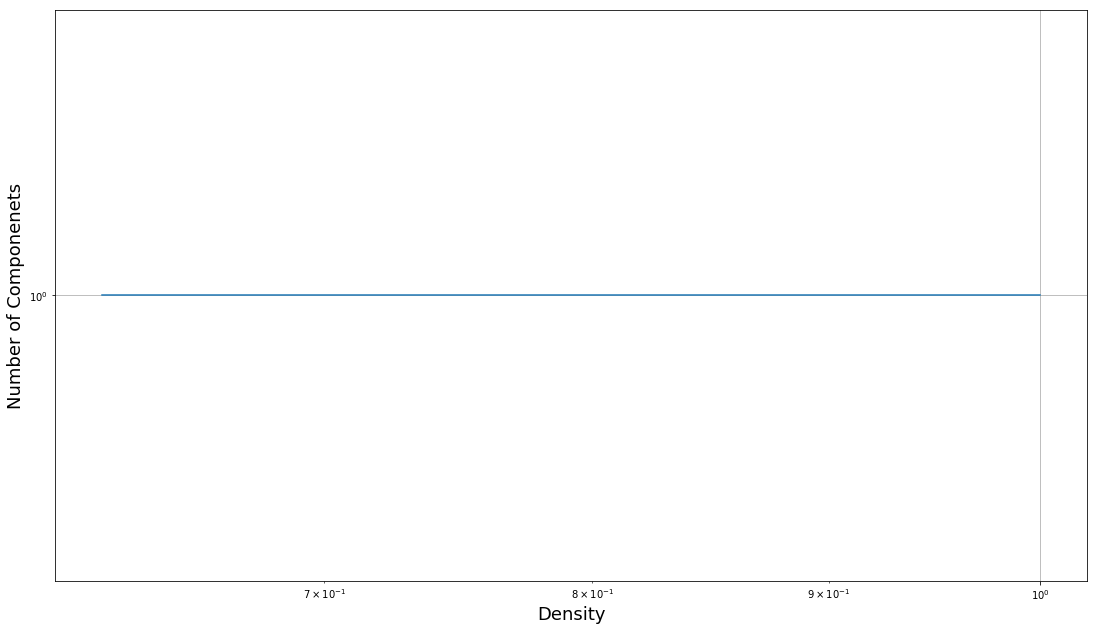

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.loglog(density,components)
ax.grid()
ax.set_xlabel("Density",fontsize=18)
ax.set_ylabel("Number of Componenets",fontsize=18)

plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100.0, top=100.0
  'bottom=%s, top=%s') % (bottom, top))


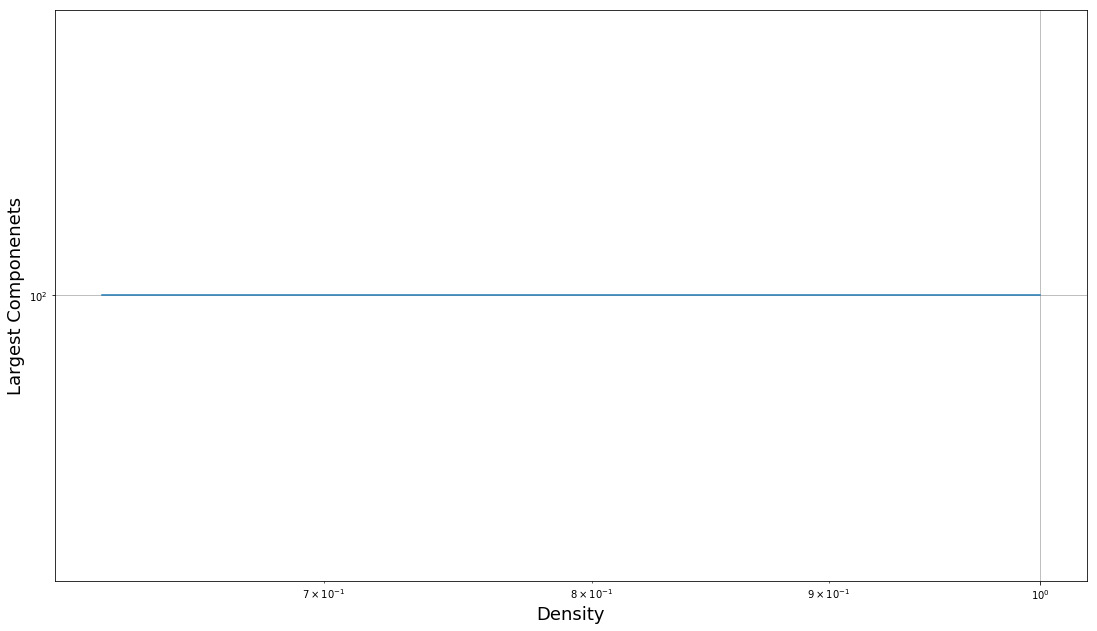

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.loglog(density,S)
ax.grid()
ax.set_xlabel("Density",fontsize=18)
ax.set_ylabel("Largest Componenets",fontsize=18)
plt.show()

# Thresholding using Node Correlation Distribution:

In [56]:
def graph_builder_local (weighted_matrix, limit):
    
    adjacency_matrix = np.zeros(weighted_matrix.shape)
    n = weighted_matrix.shape[0]
    
    for i in range(n):
        temp = np.copy(weighted_matrix[i,:])
        threshold = np.quantile(temp, limit)
        temp[temp <= threshold] = 0
        temp[temp > threshold] = 1
        adjacency_matrix[i,:] = np.copy(temp)
    G = nx.from_numpy_matrix(adjacency_matrix)
    G = G.to_undirected()
    G.remove_edges_from(G.selfloop_edges())
    componenets_number = nx.number_connected_components(G)    
    return(G, componenets_number)

In [57]:
m = weighted_matrix(data)
r = np.array([0.7,0.8,0.9,0.95,0.99])

components = []
density = []
S = []
for i in range(len(r)):
    G, c = graph_builder_local(m, r[i])
    density.append(2 * G.number_of_edges()/(len(G)*(len(G)-1)))
    S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
    components.append(c)

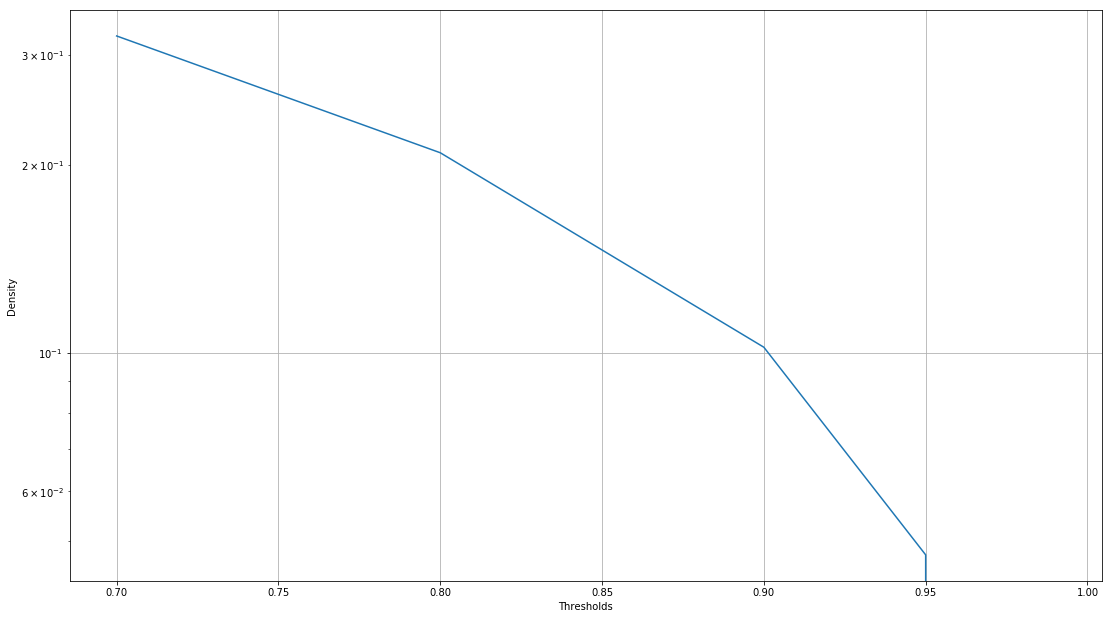

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.semilogy(r,density)
ax.grid()
ax.set_xlabel("Thresholds")
ax.set_ylabel("Density")
plt.show()

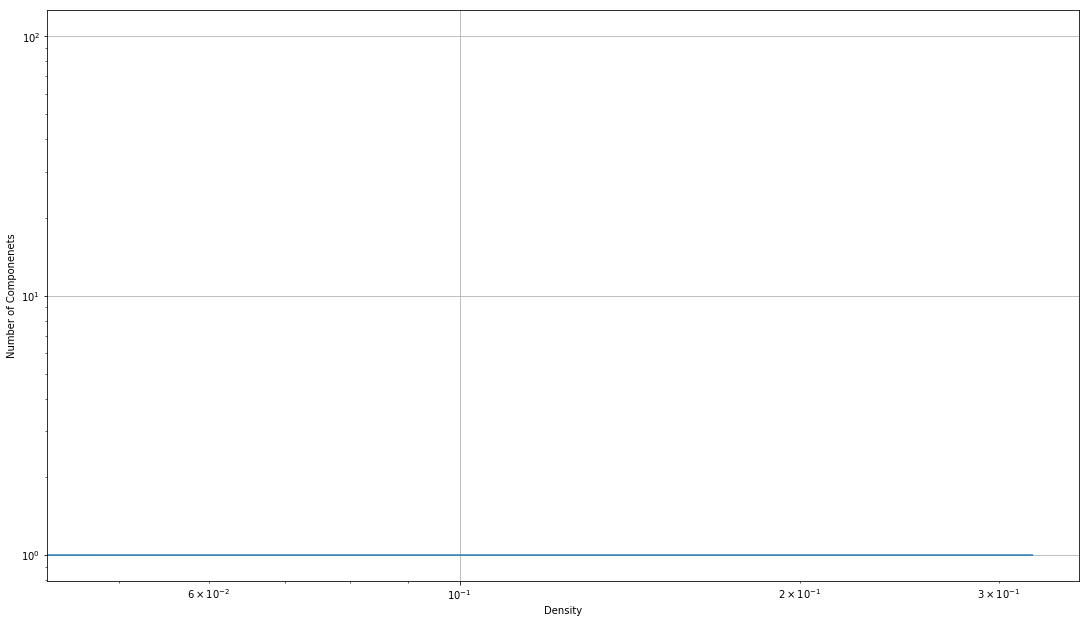

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.loglog(density,components)
ax.grid()
ax.set_xlabel("Density")
ax.set_ylabel("Number of Componenets")

plt.show()

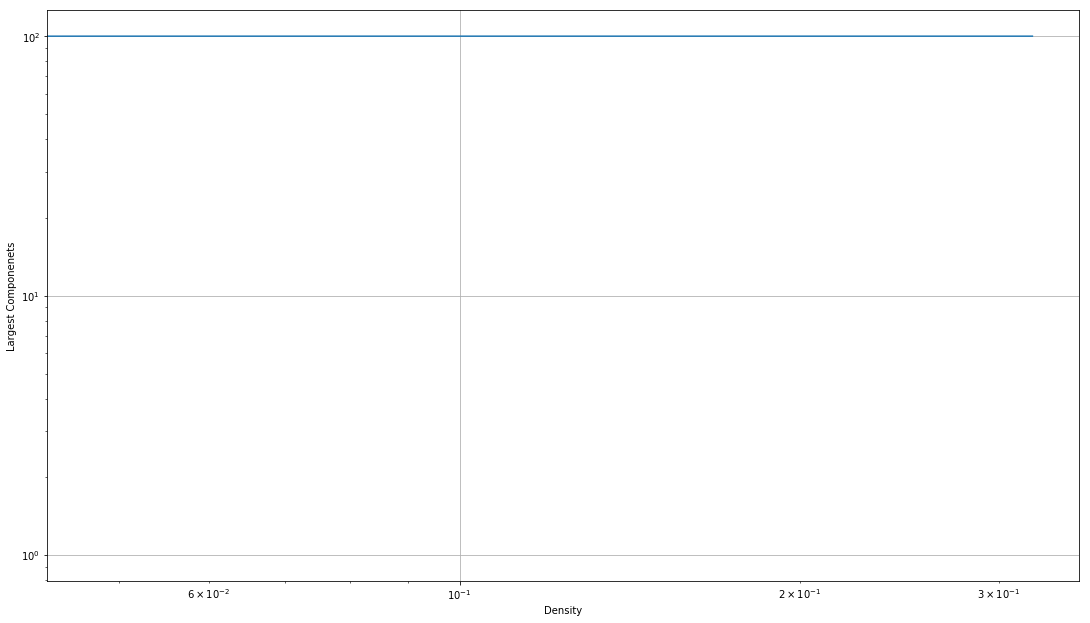

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.loglog(density,S)
ax.grid()
ax.set_xlabel("Density")
ax.set_ylabel("Largest Componenets")
plt.show()

(array([12., 21., 22., 12.,  9.,  6.,  5.,  5.,  2.,  4.,  1.,  0.,  0.,
         0.,  1.]),
 array([0.0837273 , 0.14481215, 0.20589699, 0.26698184, 0.32806669,
        0.38915153, 0.45023638, 0.51132123, 0.57240607, 0.63349092,
        0.69457577, 0.75566061, 0.81674546, 0.87783031, 0.93891515,
        1.        ]),
 <a list of 15 Patch objects>)

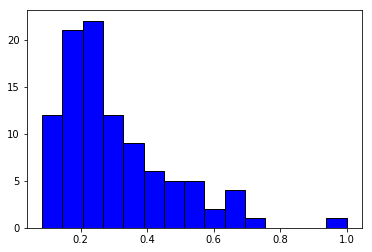

In [61]:
plt.hist(m[99,:], color = 'blue', edgecolor = 'black',bins = 15)

In [116]:
len(max(nx.connected_component_subgraphs(G), key=len))

1

In [114]:
len(Gc)

1

In [65]:
G, l = graph_builder(m)

In [66]:
l

0.46999999999999953

In [77]:
G, n = graph_builder_limit(m,0.48)

In [78]:
n

2

In [43]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

Number of nodes: 100
Number of edges: 5050


In [44]:
vk = dict(G.degree())
vk = list(vk.values())
#print('Degree', vk)
md = np.mean(vk)
print('Mean degree: ', md)

Mean degree:  101.0


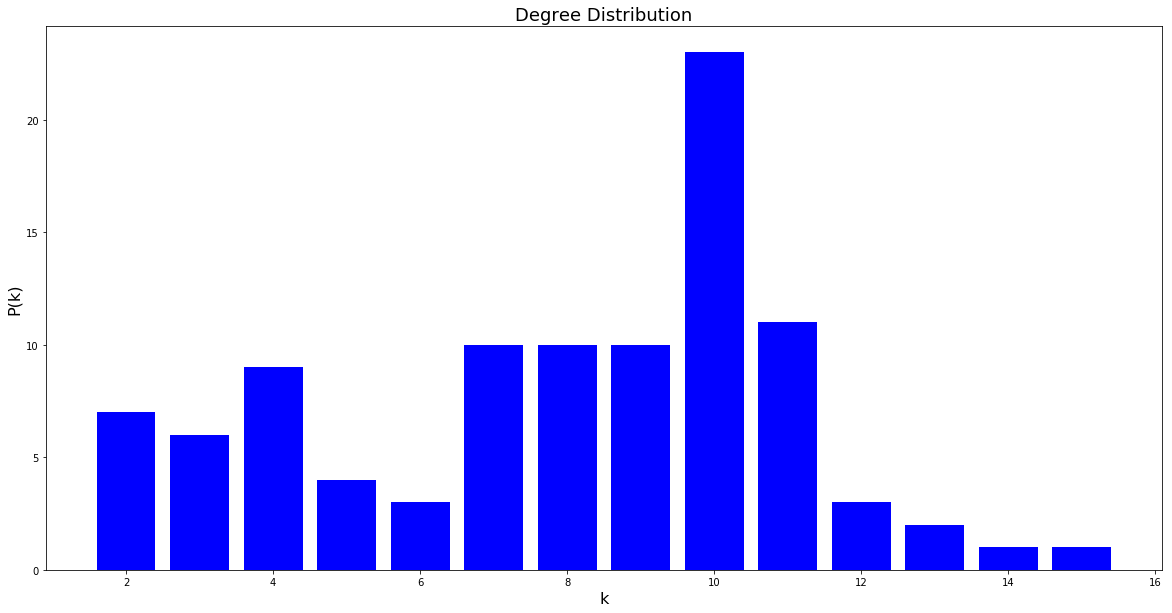

In [34]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  

degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(20,10))
#fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.xlabel("k", fontsize=16)
plt.ylabel("P(k)", fontsize=16)
plt.title("Degree Distribution", fontsize=18)
plt.show(True)